# Make synthetic data from the beta-binomial model and plot ABC SMC results

In [1]:
import numpy as np
import mystyle.sty as sty
import scipy.stats as ss
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as ss

In [2]:
sty.reset_plots()

# Make linear regression data

In [3]:
np.random.seed(1)

n_data = 30
x = np.linspace(0,10,n_data) + np.random.uniform(0,0.05,size=n_data)
gradient_truth = 1.0
intercept_truth = 122.0
sigma_truth = 2.0

y = gradient_truth*x + intercept_truth + np.random.normal(scale=sigma_truth, size=len(x))

data = np.vstack((x,y)).T

Text(0.5, 1.0, 'Data')

/home/juvid/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


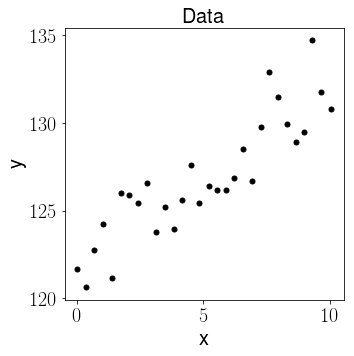

In [4]:
fig, ax = sty.plot()
ax.plot(x,y,'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')

In [5]:
np.savetxt('x.csv', data[:,0], fmt="%.8f")
np.savetxt('y.csv', data[:,1], fmt="%.8f")

In [6]:
prior_intercept_lower = prior_gradient_lower = prior_sigma_lower = 0
prior_gradient_upper = 10
prior_intercept_upper = 500
prior_sigma_upper = 10

In [7]:
lr = ss.linregress(data[:,0], data[:,1])
lr.slope, lr.intercept, np.sqrt(np.sum((data[:,1] - lr.slope*data[:,0]-lr.intercept)**2)/(len(data)-2))

(0.9982014701081334, 121.87154913978883, 1.632154675910165)

# Approximate the appropriate level of the distance metric

In [8]:
def distance_metric(simulated_data, data_y):
    return np.abs(simulated_data - data_y).sum()/len(data_y)

In [9]:
distance_metric_sims = []
for i in range(1000):
    # Simulate data with the true parameters
    simulated_data = gradient_truth*x + intercept_truth + np.random.normal(scale=sigma_truth, size=len(x))
    distance_metric_sims.append(distance_metric(simulated_data, data[:,1]))

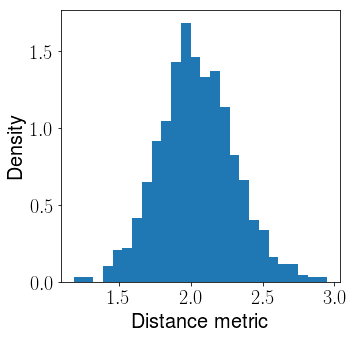

In [10]:
fig, ax = sty.plot()
ax.hist(distance_metric_sims, density=True, bins='auto')
ax.set_xlabel('Distance metric')
ax.set_ylabel('Density');

In [11]:
np.median(distance_metric_sims)

2.0275022210768494

Set the distance threshold schedule

In [12]:
distance_threshold_schedule = np.linspace(2,7.0,num=9)[::-1]
s = ''
for d in distance_threshold_schedule:
    s += f'{d}, '
s

'7.0, 6.375, 5.75, 5.125, 4.5, 3.875, 3.25, 2.625, 2.0, '

# Perform MCMC

In [13]:
linear_reg_model = pm.Model()
with linear_reg_model:
    # Regression coefs
    gradient = pm.Uniform('gradient', prior_gradient_lower, prior_gradient_upper)
    intercept = pm.Uniform('intercept', prior_intercept_lower, prior_intercept_upper)
    sigma = pm.Uniform('sigma', prior_sigma_lower, prior_sigma_upper)
    
    # Expected value
    mu = gradient*data[:,0] + intercept
       
    # Observation
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=data[:,1])

In [14]:
with linear_reg_model:
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, gradient]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:05<00:00, 2684.30draws/s]
The acceptance probability does not match the target. It is 0.8910673169661589, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806980335262423, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9120498587822345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790386945105673, but should be close to 0.8. Try to increase the number of tuning steps.


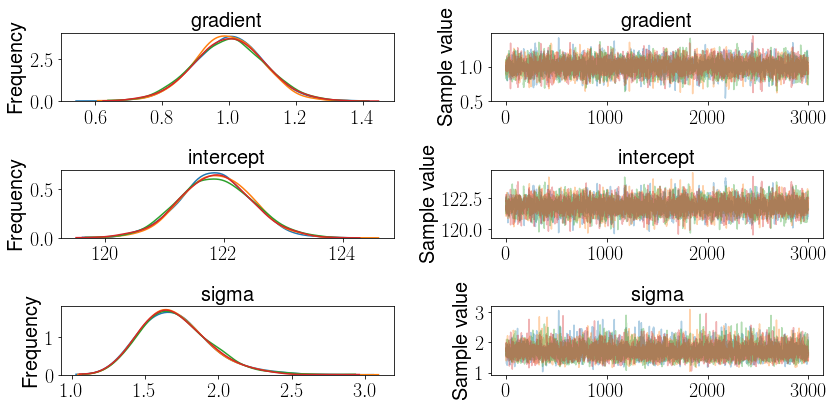

In [15]:
pm.plots.traceplot(trace);

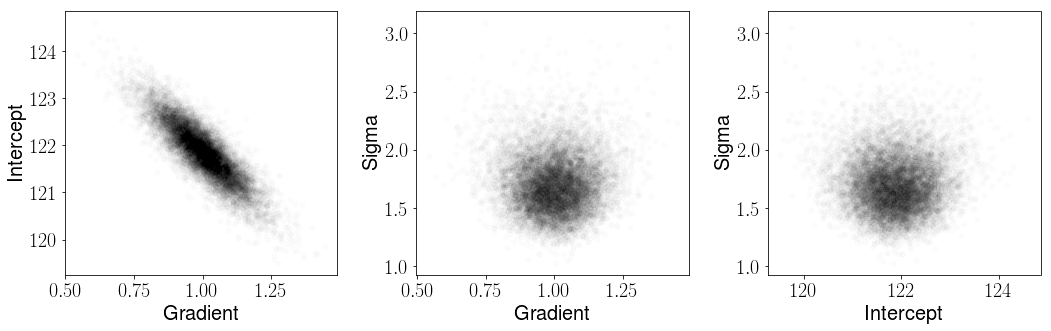

In [16]:
fig, axs = sty.plot(ncols=3)

ax = axs[0]
ax.plot(trace['gradient'], trace['intercept'], '.k', alpha=0.01)
ax.set_xlabel('Gradient')
ax.set_ylabel('Intercept')

ax = axs[1]
ax.plot(trace['gradient'], trace['sigma'], '.k', alpha=0.01)
ax.set_xlabel('Gradient')
ax.set_ylabel('Sigma')

ax = axs[2]
ax.plot(trace['intercept'], trace['sigma'], '.k', alpha=0.01)
ax.set_xlabel('Intercept')
ax.set_ylabel('Sigma')

plt.tight_layout()

## Load data from ABC SMC

In [29]:
gradients_smc = np.loadtxt('particle_0.csv', delimiter=',')
intercepts_smc = np.loadtxt('particle_1.csv', delimiter=',')
sigmas_smc = np.loadtxt('particle_2.csv', delimiter=',')
theta_smc = [gradients_smc, intercepts_smc, sigmas_smc]

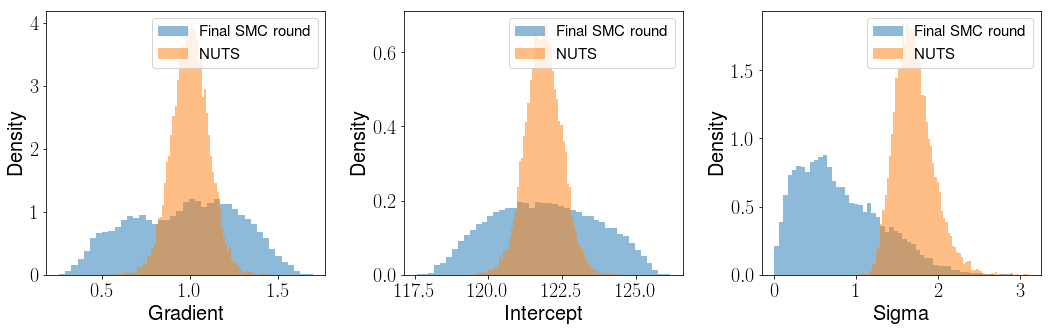

In [30]:
fig, axs = sty.plot(ncols=3)

ax = axs[0]
ax.hist(gradients_smc[:,-1], bins='auto', density=True, label=f'Final SMC round', alpha=0.5)
ax.hist(trace['gradient'], bins='auto', density=True, label='NUTS', alpha=0.5)
ax.legend()
ax.set_xlabel('Gradient')
ax.set_ylabel('Density')

ax = axs[1]
ax.hist(intercepts_smc[:,-1], bins='auto', density=True, label=f'Final SMC round', alpha=0.5)
ax.hist(trace['intercept'], bins='auto', density=True, label='NUTS', alpha=0.5)
ax.legend()
ax.set_xlabel('Intercept')
ax.set_ylabel('Density')

ax = axs[2]
ax.hist(sigmas_smc[:,-1], bins='auto', density=True, label=f'Final SMC round', alpha=0.5)
ax.hist(trace['sigma'], bins='auto', density=True, label='NUTS', alpha=0.5)
ax.legend()
ax.set_xlabel('Sigma')
ax.set_ylabel('Density')

plt.tight_layout()

In [31]:
theta_names = ['gradient', 'intercept', 'sigma']

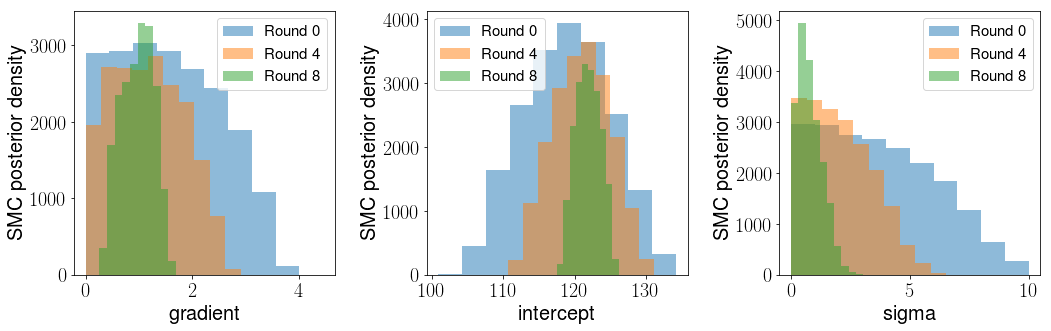

In [32]:
fig, axs = sty.plot(ncols=3)

for i, ax in enumerate(axs):
    for j in [0,4,8]:
        ax.hist(theta_smc[i][:,j], alpha=0.5, label=f'Round {j}')
    ax.legend()
    ax.set_xlabel(theta_names[i])
    ax.set_ylabel('SMC posterior density')
plt.tight_layout()

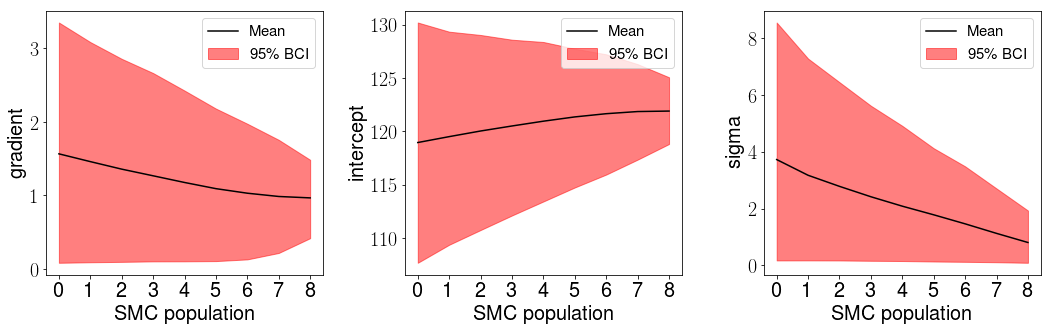

In [33]:
nrounds = gradients_smc.shape[-1]
fig, axs = sty.plot(ncols=3)

ax = axs[0]
for i, ax in enumerate(axs):
    ax.plot(np.arange(nrounds), theta_smc[i].mean(axis=0), '-k', label='Mean')
    ax.fill_between(np.arange(nrounds), np.percentile(theta_smc[i],100-2.5, axis=0), 
                    np.percentile(theta_smc[i],2.5, axis=0), color='red', alpha=0.5, label='95\% BCI')
    ax.legend()
    ax.set_xlabel('SMC population')
    ax.set_ylabel(theta_names[i])
    ax.set_xticks(np.arange(nrounds))
    ax.set_xticklabels(np.arange(nrounds))
plt.tight_layout()